# 1. Dask Dataframes
Dask dataframes can, in a nutshell, be summarized as parallel versions of dask dataframes. This is the same way that dask arrays are parallel versions of numpy arrays. A dask dataframe consists of multiple pandas dataframes. We can get an idea of what these look like below:

<img src="https://intuitive-ml-images.s3-us-west-1.amazonaws.com/computer_science/libraries-tools/dask/dask_dataframe.png" width="300">

Dask dataframes can also parallelize operations of dataframes by making use of multiple cores that are available on your system. One thing worth noting is that partition size plays a very important role in determing the speedup that can be obtained while performing computation. 

### 1.1 Features 
1. Allows parallel execution of computation on Dataframes, by utilizing multiple cores that are available in your system. Similar to how dask arrays make use of multiple cores to speed up the computation, dask dataframe does the same, simple for pandas dataframes. 
2. Dask dataframes API is very similar to pandas Dataframe API (with a few exceptions). 
3. We can load larger-than-memory data into daskdataframes. 

# 2. Exploring Dask Dataframes

In [1]:
import dask
import dask.dataframe as dd

In [32]:
df = dd.read_csv(
    "s3://intuitiveml-data-sets/country_gdp.csv",
    blocksize="150KB"
)

In [60]:
display(df)

,Country Name,Country Code,Year,Value
npartitions=4,,,,
,object,object,int64,float64
,...,...,...,...
,...,...,...,...
,...,...,...,...
,...,...,...,...


We can see that we have `4` partitions!

In [34]:
df.describe().compute()

,Year,Value
count,11507.000000,1.150700e+04
mean,1991.265230,1.005972e+12
std,15.886648,4.533056e+12
min,1960.000000,8.824448e+06
25%,1979.000000,5.234705e+09
50%,1993.000000,3.747777e+10
75%,2005.750000,1.853591e+12
max,2016.000000,7.904923e+13


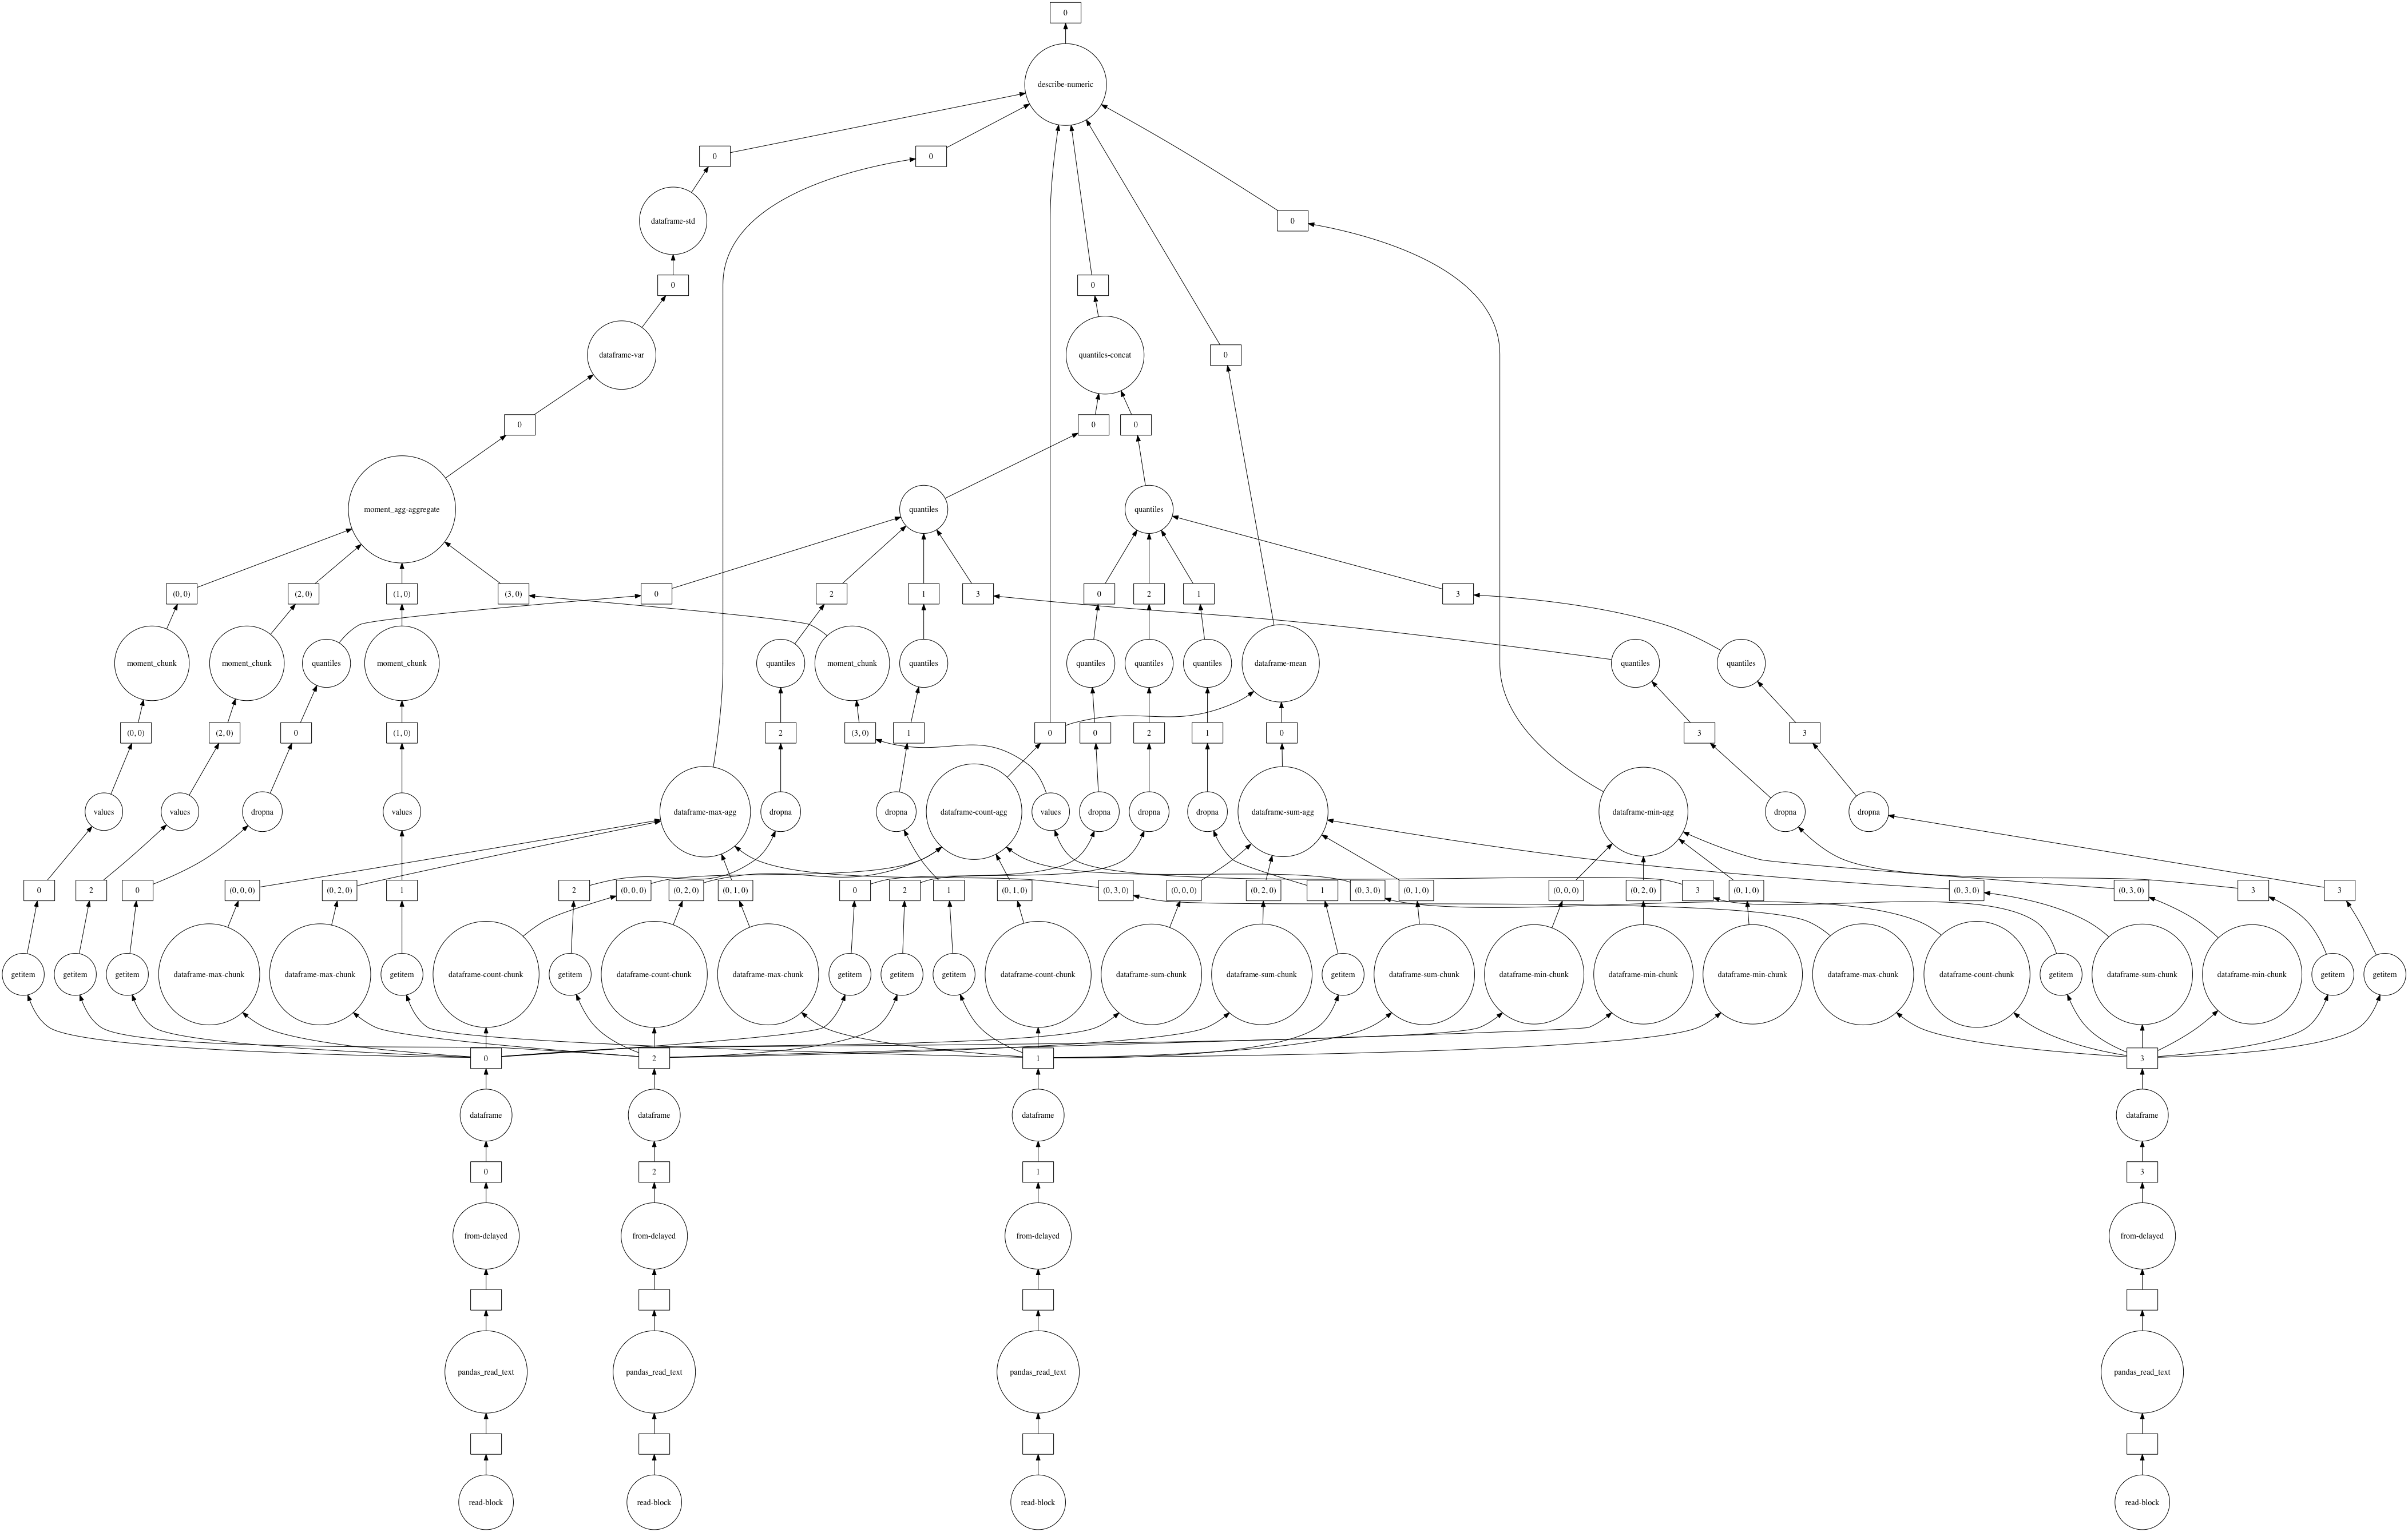

In [35]:
df.describe().visualize()

We can see that the task graph for the describe function is very complex. This is because there are so many complex operations such as mean, max, percentiles, etc. Dask also provides the `head()` function:

In [36]:
df.head()

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1968,2.576068e+10
1,Arab World,ARB,1969,2.843420e+10
2,Arab World,ARB,1970,3.138550e+10
3,Arab World,ARB,1971,3.642691e+10
4,Arab World,ARB,1972,4.331606e+10


Let's get a feel for how dask does groupbys:

In [37]:
max_gdp_per_country = df.groupby("Country Code")["Value"].max()

In [38]:
max_gdp_per_country

Dask Series Structure:
npartitions=1
    float64
        ...
Name: Value, dtype: float64
Dask Name: series-groupby-max-agg, 17 tasks

In [39]:
max_gdp_per_country.compute().head()

Country Code
ABW    2.791961e+09
AFG    2.053654e+10
AGO    1.267769e+11
ALB    1.322824e+10
AND    4.016972e+09
Name: Value, dtype: float64

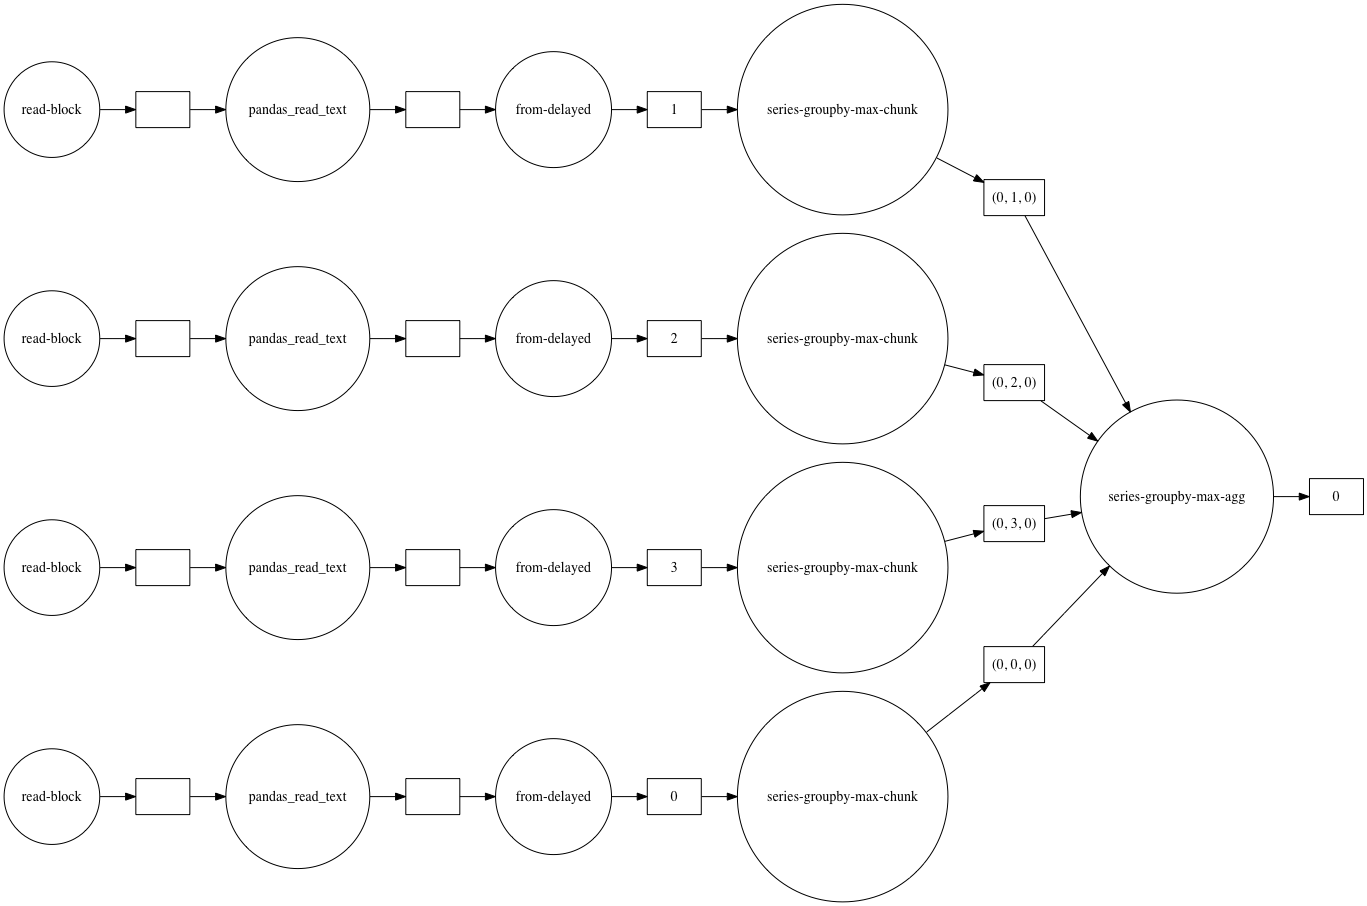

In [41]:
max_gdp_per_country.visualize(rankdir="LR")

We can then try to print the largest value by gdp:

In [45]:
df.nlargest(10, "Value").compute()

,Country Name,Country Code,Year,Value
2303,World,WLD,2014,7.904923e+13
2302,World,WLD,2013,7.699086e+13
2305,World,WLD,2016,7.584511e+13
2301,World,WLD,2012,7.488995e+13
2304,World,WLD,2015,7.475775e+13
2300,World,WLD,2011,7.327986e+13
2299,World,WLD,2010,6.595453e+13
2297,World,WLD,2008,6.346181e+13
2298,World,WLD,2009,6.016835e+13
2296,World,WLD,2007,5.785897e+13


And we can remove the `World` entry and reasses:

In [46]:
df_without_world = df[df["Country Code"] != "WLD"]

In [47]:
df_without_world.nlargest(10, "Value").compute()

,Country Name,Country Code,Year,Value
716,High income,HIC,2014,5.036240e+13
1654,OECD members,OED,2014,4.937008e+13
715,High income,HIC,2013,4.934630e+13
714,High income,HIC,2012,4.881456e+13
713,High income,HIC,2011,4.877967e+13
718,High income,HIC,2016,4.855746e+13
1653,OECD members,OED,2013,4.840520e+13
1651,OECD members,OED,2011,4.792337e+13
1652,OECD members,OED,2012,4.782850e+13
717,High income,HIC,2015,4.757751e+13


We can also filter out entries before 2010:

In [49]:
df_after_2010 = df[df.Year > 2010]

In [51]:
df_after_2010.compute().head()

,Country Name,Country Code,Year,Value
43,Arab World,ARB,2011,2.501554e+12
44,Arab World,ARB,2012,2.741239e+12
45,Arab World,ARB,2013,2.839627e+12
46,Arab World,ARB,2014,2.906616e+12
47,Arab World,ARB,2015,2.563302e+12


We can also take a look at how to apply a function to a column:

In [53]:
def add_some_text(cname, *args, **kwargs):
    return "Country name is " + cname

In [54]:
df_dummy_values = df["Country Code"].apply(add_some_text, axis=1)

/Users/natedake/.virtualenvs/intuitiveml/lib/python3.6/site-packages/dask/dataframe/core.py:2957: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Country Code', 'object'))

  warnings.warn(meta_warning(meta))


In [57]:
df_dummy_values.compute().head()

0    Country name is ARB
1    Country name is ARB
2    Country name is ARB
3    Country name is ARB
4    Country name is ARB
Name: Country Code, dtype: object

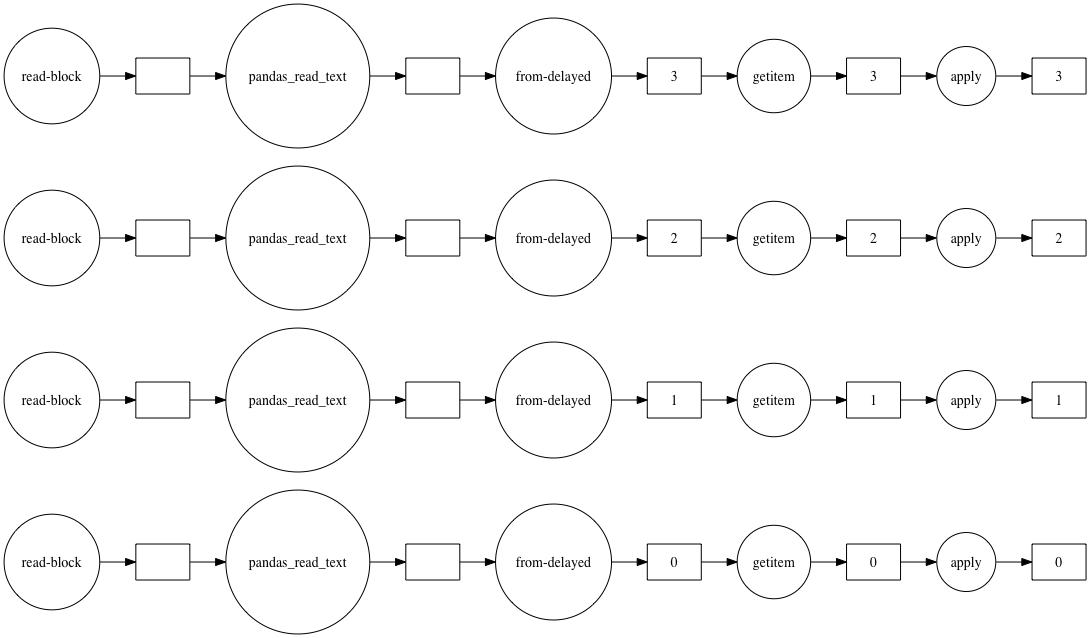

In [59]:
df_dummy_values.visualize(rankdir="LR")

For this specific situation, since this is an independent activity-the operation does not require the partitions be related to one another, or combined into a single result-the applies are performed in parallel (for each partition! remember, there are 4). 

We can look at another groupby below. Here we are finding the maximum gdp and the year it occurred, for a particular country. 

In [62]:
max_country_per_year = df.groupby("Country Code").apply(
    lambda x: x.loc[x["Value"].idxmax(), "Year"]
)

/Users/natedake/.virtualenvs/intuitiveml/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  


In [64]:
max_country_per_year.compute().head()

Country Code
AFG    2012
AGO    2014
AUS    2013
BEL    2014
BFA    2014
dtype: int64

# 3. Creating Dask Dataframes
One way to create a dask dataframe is via the `read_csv` function:

In [65]:
df = dd.read_csv(
    "s3://intuitiveml-data-sets/country_gdp.csv",
    blocksize="150KB"
)

In [66]:
df.npartitions

4

In [67]:
len(df)

11507

In [68]:
df.head()

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1968,2.576068e+10
1,Arab World,ARB,1969,2.843420e+10
2,Arab World,ARB,1970,3.138550e+10
3,Arab World,ARB,1971,3.642691e+10
4,Arab World,ARB,1972,4.331606e+10


You can also specify a glob pattern to load multiple files:

```python
df = dd.read_csv("multiples_csvs/country_gdp_data_*.csv")

```

Where the `*` is meant to denote that there are 0 or more characters (any character will match). We can even pass a list of files:

```python
import os

file_list = ["gdp_part_" + str(part) + ".csv" for part in range(0, 10)]

complete_path_list = [os.path.join("multiple_csvs", f_name) for f_name in file_list]

df = dd.read_csv(complete_path_list)


```


# 4. Loading large datasets with dask dataframes
To explore how dask handles loading large data sets, I will use the city of seattle library collection inventory, found [here](https://data.seattle.gov/Community/Library-Collection-Inventory/6vkj-f5xf). 